# Issues with 'naive' tree forecasts
## 1) Trees cannot extrapolate any trends

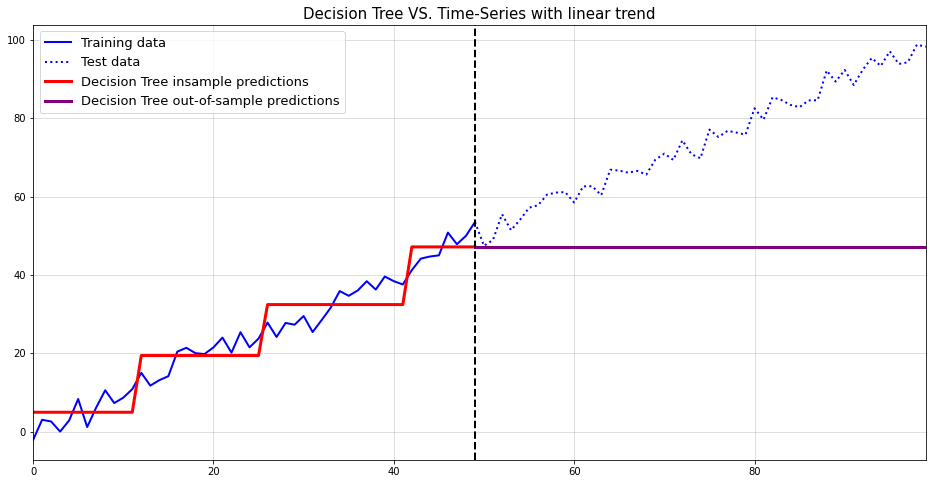

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

#create data with linear trend
np.random.seed(123)
t = np.arange(100)
y = t + 2 * np.random.normal(size = 100)#linear trend

t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)

y_train = y[:50]
y_test = y[50:]

tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(t_train, y_train)

y_pred_train = tree.predict(t_train)
y_pred_test = tree.predict(t_test)

plt.figure(figsize = (16,8))
plt.plot(t_train.reshape(-1), y_train, label = "Training data", color="blue", lw=2)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_train[-1]],y_test]), label = "Test data", 
         color="blue", ls = "dotted", lw=2)


plt.plot(t_train.reshape(-1), y_pred_train, label = "Decision Tree insample predictions", 
         color="red", lw = 3)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_pred_train[-1]],y_pred_test]), label = "Decision Tree out-of-sample predictions", 
         color="purple", lw=3)

plt.grid(alpha = 0.5)
plt.axvline(t_train[-1], color="black", lw=2, ls="dashed")
plt.legend(fontsize=13)
plt.title("Decision Tree VS. Time-Series with linear trend", fontsize=15)

plt.margins(x=0)

## 2) Trees cannot handle seasonality

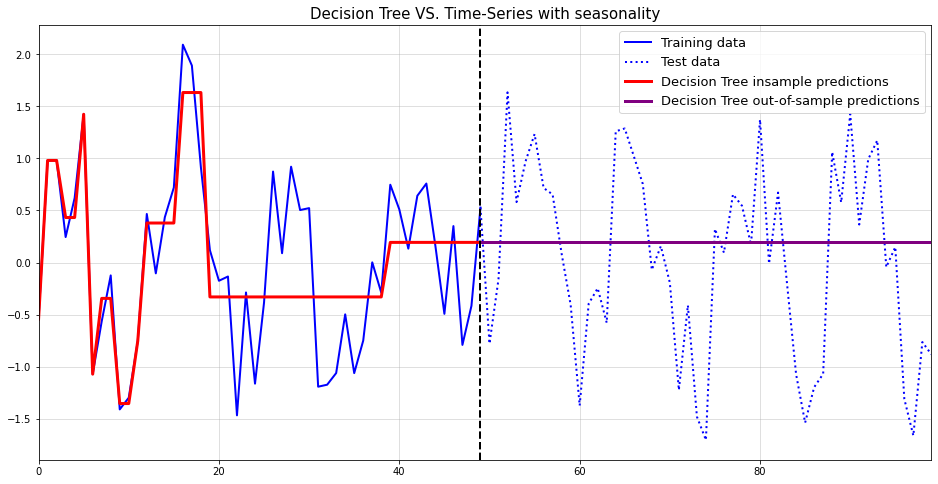

In [2]:
#create data with seasonality 
np.random.seed(123)
t = np.arange(100)
y = np.sin(0.5 * t) + 0.5 * np.random.normal(size = 100)#sine seasonality

t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)

y_train = y[:50]
y_test = y[50:]

tree = DecisionTreeRegressor(max_depth = 4)
tree.fit(t_train, y_train)

y_pred_train = tree.predict(t_train)
y_pred_test = tree.predict(t_test)

plt.figure(figsize = (16,8))
plt.plot(t_train.reshape(-1), y_train, label = "Training data", color="blue", lw=2)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_train[-1]],y_test]), label = "Test data", 
         color="blue", ls = "dotted", lw=2)


plt.plot(t_train.reshape(-1), y_pred_train, label = "Decision Tree insample predictions", 
         color="red", lw = 3)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_pred_train[-1]],y_pred_test]), label = "Decision Tree out-of-sample predictions", 
         color="purple", lw=3)

plt.grid(alpha = 0.5)
plt.axvline(t_train[-1], color="black", lw=2, ls="dashed")
plt.legend(fontsize=13)
plt.title("Decision Tree VS. Time-Series with seasonality", fontsize=15)

plt.margins(x=0)

## 3) Autoregressive Trees cannot handle trends either

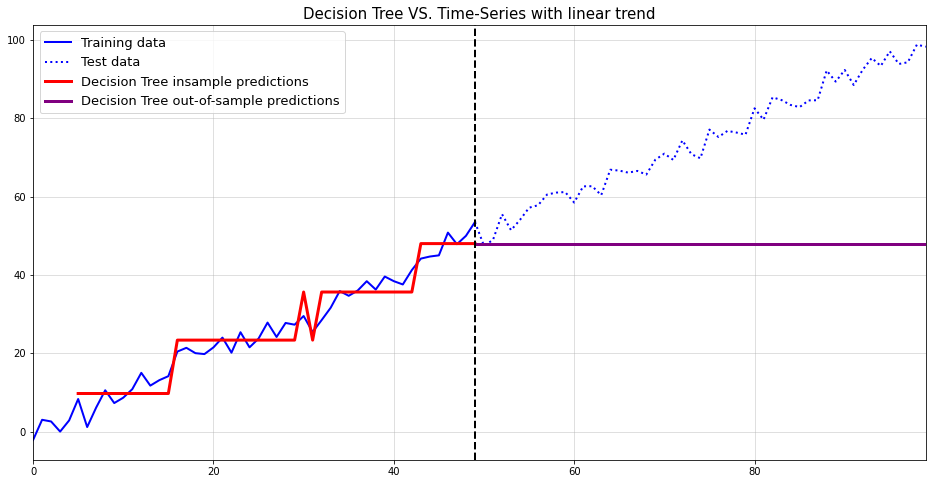

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

#create data with linear trend
np.random.seed(123)
t = np.arange(100)
y = t + 2 * np.random.normal(size = 100)#linear trend

t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)


y_train = y[:50]
X_train_shift = np.concatenate([pd.Series(y_train).shift(t).values.reshape(-1,1) for t in range(1,6)],1)[5:,:]
y_train_shift = y_train[5:]
y_test = y[50:]

tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(X_train_shift, y_train_shift)

y_pred_train = tree.predict(X_train_shift).reshape(-1)

Xt = np.concatenate([X_train_shift[-1,1:].reshape(1,-1),np.array(y_train_shift[-1]).reshape(1,1)],1)
predictions_test = []

for t in range(len(y_test)):
    pred = tree.predict(Xt)
    predictions_test.append(pred[0])
    Xt = np.concatenate([Xt[-1,1:].reshape(1,-1),np.array(pred).reshape(1,1)],1)
    
y_pred_test = np.array(predictions_test)


plt.figure(figsize = (16,8))
plt.plot(t_train.reshape(-1), y_train, label = "Training data", color="blue", lw=2)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_train[-1]],y_test]), label = "Test data", 
         color="blue", ls = "dotted", lw=2)


plt.plot(t_train.reshape(-1)[5:], y_pred_train, label = "Decision Tree insample predictions", 
         color="red", lw = 3)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_pred_train[-1]],y_pred_test]), label = "Decision Tree out-of-sample predictions", 
         color="purple", lw=3)

plt.grid(alpha = 0.5)
plt.axvline(t_train[-1], color="black", lw=2, ls="dashed")
plt.legend(fontsize=13)
plt.title("Decision Tree VS. Time-Series with linear trend", fontsize=15)

plt.margins(x=0)

# 4) Autoregressive Trees can forecast trends if we remove it first
Here, we remove the trend via first-differences

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_84684/2778805950.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  X_train_shift = pd.concat([pd.DataFrame(y_train).shift(t) for t in range(1,n_lags)],1).diff().values[n_lags:,:]


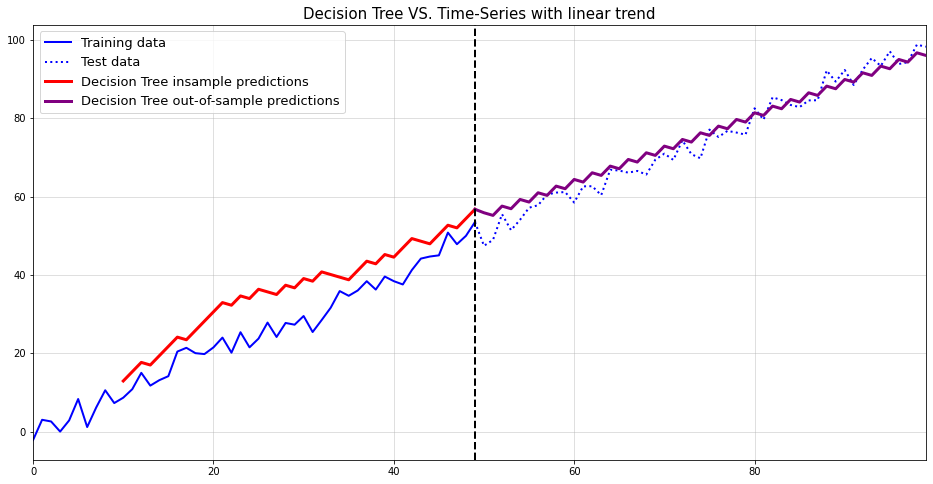

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

#create data with linear trend
np.random.seed(123)
t = np.arange(100)
y = t + 2* np.random.normal(size = 100)#linear trend

t_train = t[:50].reshape(-1,1)
t_test = t[50:].reshape(-1,1)

n_lags = 10

y_train = y[:50]
X_train_shift = pd.concat([pd.DataFrame(y_train).shift(t) for t in range(1,n_lags)],1).diff().values[n_lags:,:]
y_train_shift = np.diff(y_train)[n_lags-1:]
y_test = y[50:]

tree = DecisionTreeRegressor(max_depth = 1)
tree.fit(X_train_shift, y_train_shift)

y_pred_train = tree.predict(X_train_shift).reshape(-1)

Xt = np.concatenate([X_train_shift[-1,1:].reshape(1,-1),np.array(y_train_shift[-1]).reshape(1,1)],1)
predictions_test = []

for t in range(len(y_test)):
    pred = tree.predict(Xt)
    predictions_test.append(pred[0])
    Xt = np.concatenate([np.array(pred).reshape(1,1),Xt[-1,1:].reshape(1,-1)],1)
    
y_pred_test = np.array(predictions_test)

y_pred_train = y_train[n_lags-2]+np.cumsum(y_pred_train)
y_pred_test = y_train[-1]+np.cumsum(y_pred_test)



plt.figure(figsize = (16,8))
plt.plot(t_train.reshape(-1), y_train, label = "Training data", color="blue", lw=2)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_train[-1]],y_test]), label = "Test data", 
         color="blue", ls = "dotted", lw=2)


plt.plot(t_train.reshape(-1)[n_lags:], y_pred_train, label = "Decision Tree insample predictions", 
         color="red", lw = 3)
plt.plot(np.concatenate([np.array(t_train[-1]),t_test.reshape(-1)]), 
         np.concatenate([[y_pred_train[-1]],y_pred_test]), label = "Decision Tree out-of-sample predictions", 
         color="purple", lw=3)

plt.grid(alpha = 0.5)
plt.axvline(t_train[-1], color="black", lw=2, ls="dashed")
plt.legend(fontsize=13)
plt.title("Decision Tree VS. Time-Series with linear trend", fontsize=15)

plt.margins(x=0)

# Probabilistic forecasting with Random Forests
[Dataset](https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting)


Text(0.5, 1.0, 'Alcohol Sales')

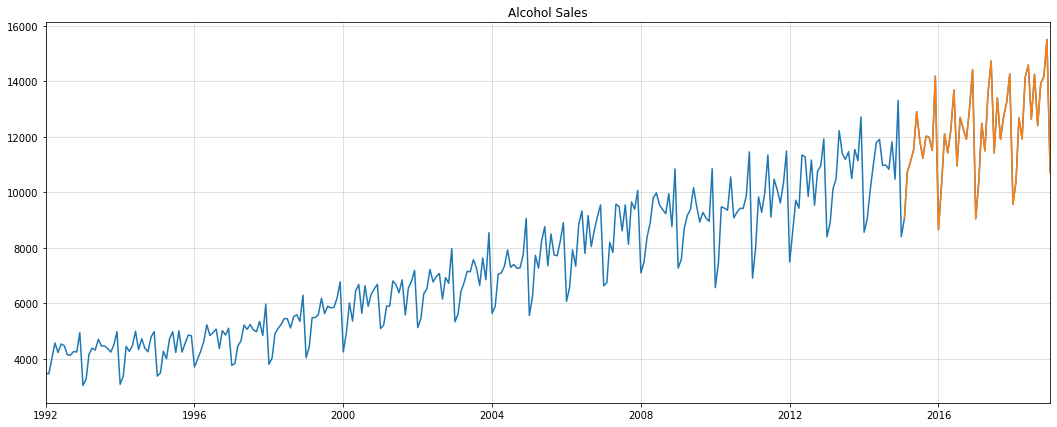

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Alcohol_Sales.csv")
df.columns = ["date", "sales"]
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df_train = df.iloc[:-48]
df_test = df.iloc[-48:]

plt.figure(figsize = (18,7))
plt.plot(df, label="Training data")
plt.plot(df_test, label = "Test data")
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.title("Alcohol Sales")




## Make time-series stationary
- shift from positive only to all reals via log
- remove trend via first-order differencing
- remove yearly seasonlity via 12th-order differencing

## Fit Random Forest model and perform forecast

In [6]:
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy


class RandomForestARModel():
    """
    Autoregressive forecasting with Random Forests
    """
    
    def __init__(self, n_lags=1, max_depth = 3, n_estimators=1000, random_state = 123,
                 log_transform = False, first_differences = False, seasonal_differences = None):
        """
        Args:
            n_lags: Number of lagged features to consider in autoregressive model
            max_depth: Max depth for the forest's regression trees
            random_state: Random state to pass to random forest
            
            log_transform: Whether the input should be log-transformed
            first_differences: Whether the input should be singly differenced
            seasonal_differences: Seasonality to consider, if 'None' then no seasonality is presumed
        """
        
        self.n_lags = n_lags
        self.model = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, random_state = random_state)
        
        self.log_transform = log_transform
        self.first_differences = first_differences
        self.seasonal_differences = seasonal_differences
        
        
        
    def fit(self, y):
        """
        Args:
            y: training data (numpy array or pandas series/dataframe)
        """
        #enable pandas functions via dataframes
        y_df = pd.DataFrame(y)
        self.y_df = deepcopy(y_df)
        
        #apply transformations and store results for retransformations
        if self.log_transform:
            y_df = np.log(y_df)
            self.y_logged = deepcopy(y_df)
        
        if self.first_differences:
            y_df = y_df.diff().dropna()
            self.y_diffed = deepcopy(y_df)
        
        if self.seasonal_differences is not None:
            y_df = y_df.diff(self.seasonal_differences).dropna()
            self.y_diffed_seasonal = deepcopy(y_df)
        
        
        #get lagged features
        Xtrain = pd.concat([y_df.shift(t) for t in range(1,self.n_lags+1)],axis=1).dropna()
        self.Xtrain = Xtrain
        
        ytrain = y_df.loc[Xtrain.index,:]
        self.ytrain = ytrain

        self.model.fit(Xtrain.values,ytrain.values.reshape(-1))

    
    
    def sample_forecast(self, n_periods = 1, n_samples = 10000, random_seed =123):
        """
        Draw forecasting samples by randomly drawing from all trees in the forest per forecast period
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = self._perform_forecast(n_periods, n_samples, random_seed)
        output = self._retransform_forecast(samples, n_periods)
        
        return output
    
    
    
    def _perform_forecast(self, n_periods, n_samples, random_seed):
        """
        Forecast transformed observations
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = []
        
        np.random.seed(random_seed)
        for i in range(n_samples):
            #store lagged features for each period
            Xf = np.concatenate([self.Xtrain.iloc[-1,1:].values.reshape(1,-1),
                                 self.ytrain.iloc[-1].values.reshape(1,1)],1)

            forecasts = []

            for t in range(n_periods):
                tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
                pred = tree.predict(Xf)[0]
                forecasts.append(pred)
                
                #update lagged features for next period
                Xf = np.concatenate([Xf[:,1:],np.array([[pred]])],1)
            
            samples.append(forecasts)
        
        return samples
    
    
    
    def _retransform_forecast(self, samples, n_periods):
        """
        Retransform forecast (re-difference and exponentiate)
        Args:
            samples: Forecast samples for retransformation
            n_periods: Ammount of periods to forecast
        """
        
        full_sample_tree = []

        for samp in samples:
            draw = np.array(samp)
            
            #retransform seasonal differencing
            if self.seasonal_differences is not None:
                result = list(self.y_diffed.iloc[-self.seasonal_differences:].values)
                for t in range(n_periods):
                    result.append(result[t]+draw[t])
                result = result[self.seasonal_differences:]
            else:
                result = []
                for t in range(n_periods):
                    result.append(draw[t])
            
            #retransform first differences
            y_for_add = self.y_logged.values[-1] if self.log_transform else self.y_df.values[-1]
            
            if self.first_differences:
                result = y_for_add + np.cumsum(result)
            
            #retransform log transformation
            if self.log_transform:
                result = np.exp(result)
            
            full_sample_tree.append(result.reshape(-1,1))

        return np.concatenate(full_sample_tree,1)

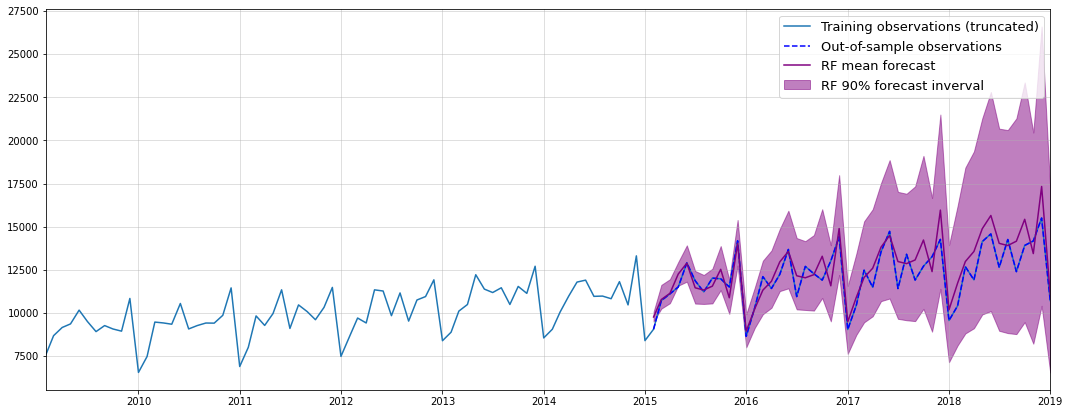

In [7]:
model = RandomForestARModel(n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest,1)
lowers_forest = np.quantile(predictions_forest,0.05,1)
uppers_forest = np.quantile(predictions_forest,0.95,1)

plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_forest,color="purple", label = "RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label = "RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

## Benchmark fitting a kernel density model to the differenced time-series
=> assumes that all autocorrelation has been removed via differencing  
=> see also [here](https://www.sarem-seitz.com/facebook-prophet-covid-and-why-i-dont-trust-the-prophet/#:~:text=An-,even,-simpler%20forecast%20model)

In [8]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(df_train_trans.values[:,0])

target_range = np.linspace(np.min(df_train_trans.values[:,0])-0.5,np.max(df_train_trans.values[:,0])+0.5,num=100)



full_sample_toy = [] 
np.random.seed(123)
for i in range(10000):
    draw = kde.resample(len(df_test)).reshape(-1)
    result = list(df_train_diffed.iloc[-12:].values)

    for t in range(len(df_test)):
        result.append(result[t]+draw[t])

    full_sample_toy.append(np.exp(np.array((np.log(df_train.values[-1])+np.cumsum(result[12:]))).reshape(-1,1)))

    
predictions_toy = np.concatenate(full_sample_toy,1)
means_toy = np.mean(predictions_toy,1)
lowers_toy = np.quantile(predictions_toy,0.05,1)
uppers_toy = np.quantile(predictions_toy,0.95,1)

plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_toy,color="red", label = "Benchmark mean forecast")

plt.fill_between(df_test.index, lowers_toy, uppers_toy, color="red", alpha=0.5, label = "Benchmark 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

NameError: name 'df_train_trans' is not defined

In [ ]:
plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_tree,color="purple", label = "RF mean forecast",lw = 3)
plt.plot(df_test.index,means_toy,color="red", label = "Benchmark mean forecast", lw = 3)

plt.legend(fontsize=13)
plt.margins(x=0)

## RMSE evaluation Random Forest VS. Benchmark

In [ ]:
np.sqrt(np.mean((df_test.values[:,0] - means_tree)**2))

In [ ]:
np.sqrt(np.mean((df_test.values[:,0] - means_toy)**2))